In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-02-21 19:04:15.622122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 19:04:15.622246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 19:04:15.791844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = pathlib.Path('../input/dog-vs-cat-classification/train/train')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000


In [3]:
batch_size = 32
img_height = 227
img_width = 227

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


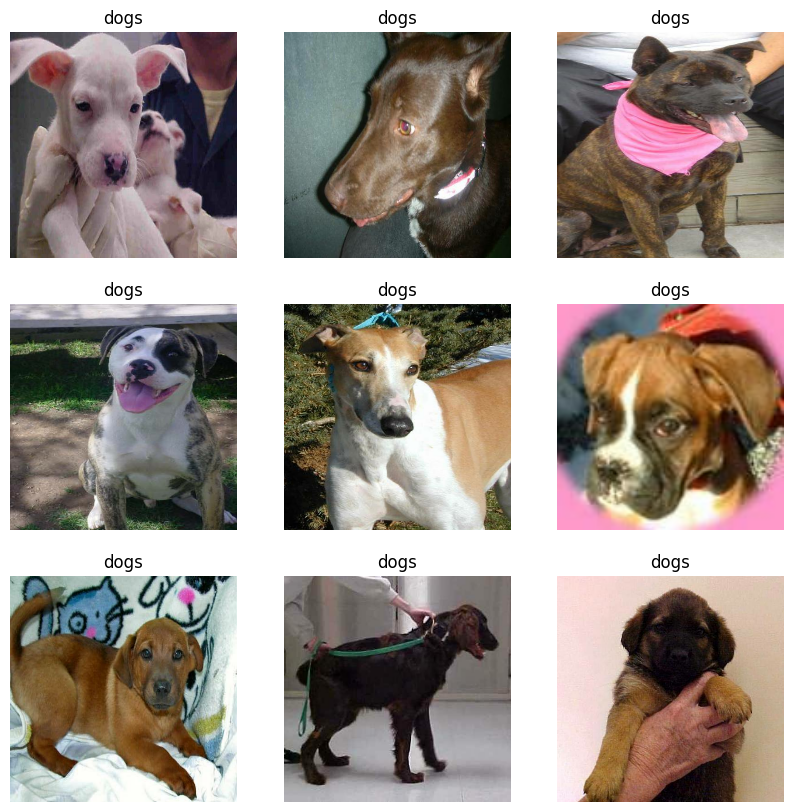

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

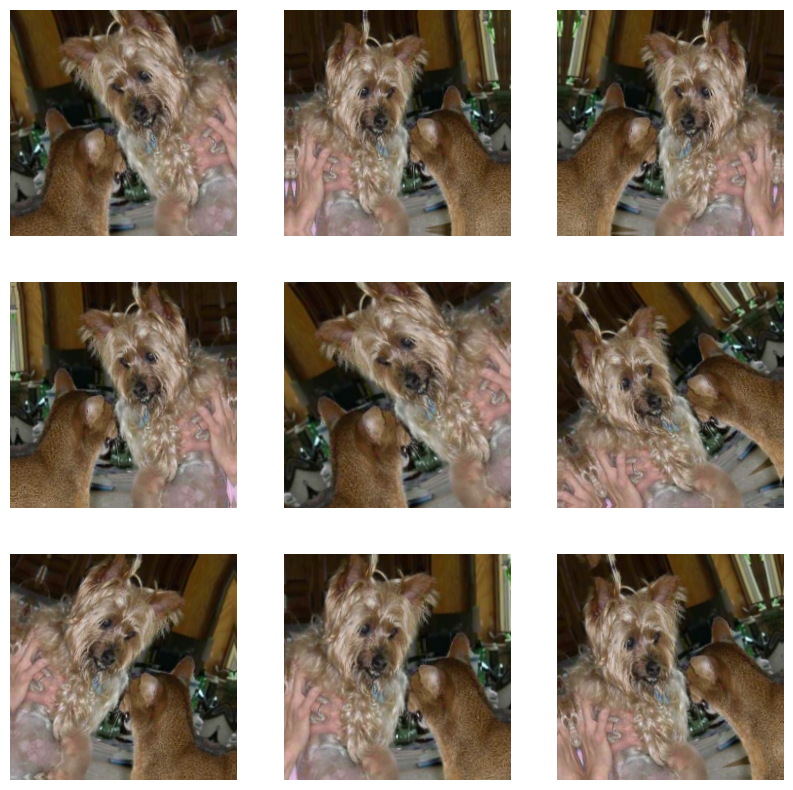

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
num_classes = len(class_names)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
# model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255),
    
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
    
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
    
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
    
#     layers.Dense(num_classes)
# ])


model = Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
# Layer 1
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Layer 2
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Layer 3
model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

# Layer 4
model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

# Layer 5
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1000, activation='relu'))  # Adjust the number of neurons as needed

model.add(Dense(2, activation='softmax'))  # 1000 classes for ImageNet

# Print the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)      

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1708542358.264469      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 56s 70ms/step - loss: 0.8653 - accuracy: 0.6212 - val_loss: 0.6530 - val_accuracy: 0.6186
Epoch 2/50
625/625 [==============================] - 36s 58ms/step - loss: 0.5688 - accuracy: 0.7085 - val_loss: 0.6334 - val_accuracy: 0.6576
Epoch 3/50
625/625 [==============================] - 36s 58ms/step - loss: 0.5105 - accuracy: 0.7604 - val_loss: 0.4636 - val_accuracy: 0.7766
Epoch 4/50
625/625 [==============================] - 36s 58ms/step - loss: 0.4339 - accuracy: 0.8012 - val_loss: 0.7199 - val_accuracy: 0.6802
Epoch 5/50
625/625 [==============================] - 37s 59ms/step - loss: 0.3892 - accuracy: 0.8265 - val_loss: 0.4426 - val_accuracy: 0.7936
Epoch 6/50
625/625 [==============================] - 37s 59ms/step - loss: 0.3469 - accuracy: 0.8486 - val_loss: 0.3894 - val_accuracy: 0.8282
Epoch 7/50
625/625 [==============================] - 37s 59ms/step - loss: 0.3231 - accuracy: 0.8598 - val_loss: 0.4158 - val_accuracy: 0.7964
Epo

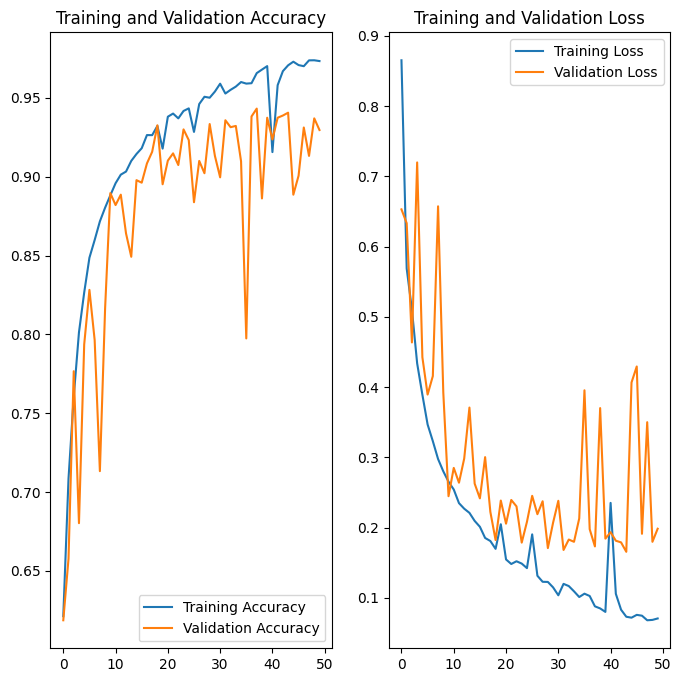

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
test_filenames = os.listdir("../input/dog-vs-cat-classification/test/test")
test_df = pd.DataFrame({
    'id': test_filenames
})

In [14]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/dog-vs-cat-classification/test/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(227,227),
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames.


In [15]:
predict = model.predict(test_generator)
test_df['labels'] = np.argmax(predict, axis=-1)

250/250 [==============================] - 45s 181ms/step


In [16]:
test_df

,id,labels
0,005463.jpg,0
1,000304.jpg,1
2,001940.jpg,1
3,007289.jpg,1
4,005491.jpg,0
...,...,...
7995,004881.jpg,0
7996,003638.jpg,0
7997,007845.jpg,0
7998,007882.jpg,1


In [17]:
test_df.set_index('id')
test_df.to_csv('submission.csv',index=False)